In [81]:
# Importing the needed libraries:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
import math
import statistics

# For debug purposes only. To be removed.
import time

In [82]:
# Meixner process parameters. With subordinator.
a = 0.1231
b = -0.5875
d = 3.3588

kappa = 0.5705
eta = 1.5863
lamb = 1.9592
y0 = 1

r = 1.9/100 
q = 1.2/100

S0 = 1124.47

In [83]:
# time_points is the list of points in which we simulate the process at
def BM_path(time_points):
    trajectory = [0]
    for t in range(1, len(time_points)):
        realization = trajectory[-1]+np.sqrt(time_points[t]-time_points[t-1])*np.random.normal()
        trajectory.append(realization)
    return dict(zip(time_points,trajectory))

In [84]:
def poisson_path(intensity, time_points):
    i = intensity*(time_points[1]-time_points[0])
    trajectory = [0]
    for t in time_points:
        trajectory.append(trajectory[-1]+np.random.poisson(i))
    return dict(zip(time_points, trajectory))

In [85]:
# this is defined so that we do not repeatedly compute the integrals inside the meixner trajectory function
def meix_optimization(k, alpha):
    # density function of the meixner measure
    def meixner_meas(x):
        return d*(np.exp(b*x/a)/(x*np.sinh(np.pi*x/a)))
    
    # partitioning via inverse linear boundaries method
    def ilb_partition(k, alpha):
        lhs = [-alpha/i for i in range(1,k+2)]
        rhs = [-x for x in reversed(lhs)]
        return lhs, rhs
        
    # we could experiment with these values
    left_part, right_part = ilb_partition(k,alpha)
    partition = left_part + right_part
    
    # intensities for our Poisson processes
    left_lambdas = [integrate.quad(meixner_meas, left_part[i], left_part[i+1])[0] for i in range(len(left_part)-1)]
    right_lambdas = [integrate.quad(meixner_meas, right_part[i], right_part[i+1])[0] for i in range(len(right_part)-1)]
    lambdas = left_lambdas + right_lambdas
    
    # will be used later on to compute the c's
    x_sqrd = lambda x : x**2*meixner_meas(x) if x!=0 else 0

    # epsilon must be > 0
    def sigma_sqrd(epsilon):
        return integrate.quad(x_sqrd, -epsilon, epsilon)[0]

    # variance of the poisson processes
    c_left = [-np.sqrt(integrate.quad(x_sqrd, left_part[i], left_part[i+1])[0]/left_lambdas[i]) for i in range(len(left_part)-1)]
    c_right = [np.sqrt(integrate.quad(x_sqrd, right_part[i], right_part[i+1])[0]/right_lambdas[i]) for i in range(len(right_part)-1)]
    c = c_left + c_right
    
    # drift
    gamma_ = a*d*np.tan(b/2)-2*d*(integrate.quad(lambda x: np.sinh(b*x/a)/np.sinh(np.pi*x/a), 1, 20)[0])
    
    # used to incorporate the small jumps
    sigma_ = np.sqrt(sigma_sqrd(right_part[0]))
    
    return partition, lambdas, c, gamma_, sigma_

indicator = lambda cond : 1 if cond else 0

In [123]:
partition, lambdas, c, gamma_, sigma_ = meix_optimization(150, 1)

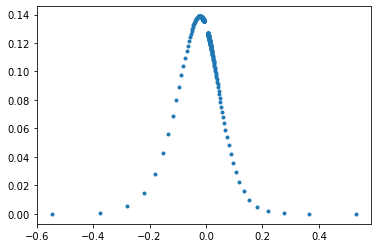

In [124]:
plt.plot(c,lambdas,".")

In [125]:
def meixner_trajectory(time_points):
    # the actual trajectory of the meixner process starts here
    bm = BM_path(time_points)
    N = [poisson_path(l, time_points) for l in lambdas]
    
    trajectory = []
    for t in time_points:
        s = [c[j]*( N[j][t] - lambdas[j]*t*indicator(np.abs(c[j]) < 1) ) for j in range(len(c))]
        #s = [c[j]*( N[j][t] - lambdas[j]*t) for j in range(200)]
        realization = gamma_*t + sigma_*bm[t] + sum(s)
        #realization = sigma_*bm[t] + sum(s)
        trajectory.append(realization)
    return dict(zip(time_points,trajectory))

In [126]:
def cir(T, time_points):
    increment = T/time_points
    y = np.zeros(time_points)
    y[0] = y0
    for i in range(time_points-1):
        y[i+1] = max(y[i] + kappa * (eta - y[i]) * increment + lamb * math.sqrt(y[i])*math.sqrt(increment) * np.random.normal(0,1),0)
    return y

In [127]:
def int_cir(T, time_points):
    Y = np.zeros(time_points+1)
    Y[0] = y0
    fixed_cir = cir(T, time_points)
    for i in range(len(cir(T, time_points))):
        Y[i+1] = Y[i] + fixed_cir[i]
    return dict(zip([T/time_points * i for i in range(time_points+1)], Y/time_points))

In [128]:
def subordinated_meixner(T, time_points):
    path = int_cir(T, time_points)
    det_time = list(path.keys())
    t_points = list(path.values())
    sub_meix = list(meixner_trajectory(t_points).values())
    return dict(zip(det_time, sub_meix))

In [129]:
def subordinated_meixner2(T, time_points):
    path = int_cir(T, time_points)
    t_points = list(path.values())
    sub_meix = list(meixner_trajectory(t_points).values())
    return dict(zip(t_points, sub_meix))

In [130]:
def psi_X(t, u):
    return np.log((np.cos(b/2)/np.cosh(complex(a*u,-b)/2))**(2*d))

In [131]:
def sub_e(t,u):
    coth = lambda x : np.cosh(x)/np.sinh(x) if x != 0 else 0
    def phi_cir(t, u):
        gamma = np.sqrt(complex(kappa**2, -2*lamb**2*u))
        return np.exp(kappa**2*eta*t/(lamb**2))*np.exp(complex(0,2*y0*u)/(kappa + gamma*coth(gamma*t/2)))/((np.cosh(gamma*t/2) + kappa/gamma*np.sinh(gamma*t/2))**(2*kappa*eta/lamb**2))

    def psi_X(t, u):
        return np.log((np.cos(b/2)/np.cosh(complex(a*u,-b)/2))**(2*d))

    def phi(t, u):
        return np.exp(complex(0, u*((r-q)*t)))*(phi_cir(t, complex(0,-psi_X(t, u))))/(phi_cir(t, complex(0,-psi_X(t, complex(0,-1)))))**complex(0,u)

    exp_value = phi(t, complex(0,-1)*psi_X(t,u))
    return np.real(exp_value)

In [132]:
def sub2_e(t,u):
    def psi_X(t, u):
        return np.log((np.cos(b/2)/np.cosh(complex(a*u,-b)/2))**(2*d))
    def A(t,u):
        gamma = np.sqrt(kappa**2 - complex(0, 2*lamb**2*u))
        return np.exp(kappa**2 * eta * t/lamb**2) / (np.cosh(gamma*t/2) + (kappa/gamma) * np.sinh(gamma*t/2))**(2*kappa*eta/lamb**2)
    coth = lambda x : np.cosh(x)/np.sinh(x) if x != 0 else np.inf
    def B(t,u):
        gamma = np.sqrt(kappa**2 - complex(0, 2*lamb**2*u))
        return 2*complex(0,1)*u/(kappa + gamma * coth(gamma*t/2))
    def ch_func(t,u):
        return A(t,u)*np.exp(B(t,u) * y0)
    exp_value2 = ch_func(t, complex(0,-1) * psi_X(t,u))
    return np.real(exp_value2)

In [133]:
def meixner_sub_martingale(T, time_points):
    path_meixner = subordinated_meixner2(T, time_points)
    yt = np.array(list(path_meixner.keys()))
    x_yt = np.array(list(path_meixner.values()))
    det_time = np.array([i/len(x_yt) * T for i in range(len(x_yt))])
    correction = []
    for i in range(len(x_yt)):
        correction.append(np.exp((r-q)*yt[i])/sub2_e(det_time[i],complex(0,-1)))
    risk_neutral = S0*np.array(correction) * np.exp(x_yt)
    return dict(zip(det_time, list(risk_neutral)))

# Monte Carlo simulations with Subordinator

In [134]:
def payoff_eur_call(ST, K):
    return max(ST-K,0)

In [135]:
def mc_ec_sub_meixner(T, K, sims):
    t=[]
    for i in range(sims):
        final_value = list(meixner_sub_martingale(T,250).values())[-1]
        t.append(payoff_eur_call(final_value, K))
    return np.exp(-r*T)*np.mean(t)

In [138]:
%%time
resl = mc_ec_sub_meixner(338/365, 1225, 1000)

<ipython-input-132-2a08bf162ec8>:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  return 2*complex(0,1)*u/(kappa + gamma * coth(gamma*t/2))


Wall time: 5min 26s


In [139]:
resl

38.94333042277027

In [141]:
K_list = [1025,1100,1125,1150,1175,1200,1225,1250,1275,1300,1325]
prices_list = [146.50,96.20,81.7,68.30,56.6,46.1,36.9,29.3,22.5,17.2,12.8]

mc_predictions = [142.51, 94.41, 81.49, 66.09, 54.72, 47.26, 38.27, 29.77, 24.12,18.31,15.99]

the_reveal = list(zip(mc_predictions, prices_list))

arpe = 1/len(the_reveal)*sum([abs(market - model)/market for model, market in the_reveal])

print(arpe*100)

5.255185349966806


In [39]:
K_list = [1025,1100,1125,1150,1175,1200,1225,1250,1275,1300,1325]
prices_list = [146.50,96.20,81.7,68.30,56.6,46.1,36.9,29.3,22.5,17.2,12.8]

mc_predictions = []
for k in K_list:
    mc_predictions.append(mc_ec_sub_meixner(338/365, k, 1000))
the_reveal = list(zip(mc_predictions, prices_list))

<ipython-input-29-2a08bf162ec8>:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  return 2*complex(0,1)*u/(kappa + gamma * coth(gamma*t/2))


In [40]:
arpe = 1/len(the_reveal)*sum([abs(market - model)/market for model, market in the_reveal])

In [41]:
print(arpe)

0.11974882178903719


In [42]:
the_reveal

[(139.6519443717548, 146.5),
 (87.85328710222134, 96.2),
 (81.49271838708233, 81.7),
 (66.08535263424658, 68.3),
 (56.559724652478714, 56.6),
 (47.26241260362092, 46.1),
 (38.273372849967274, 36.9),
 (29.769432286956008, 29.3),
 (24.116589439795213, 22.5),
 (20.35913429669276, 17.2),
 (23.220225163877487, 12.8)]

In [57]:
path = subordinated_meixner(337/365, 300)
t = np.array(list(path.keys()))
x_yt = np.array(list(path.values()))
correction = []
for cir_times in t:
    correction.append(np.exp((r-q)*cir_times)/sub2_e(cir_times,complex(0,-1)))
S0 * np.array(correction) * np.exp(x_yt)

array([1661.33356348, 1140.55205704, 1143.51635383, 1140.90927931,
       1141.06221684, 1143.22251801, 1139.0808088 , 1139.88527099,
       1131.19081001, 1131.55195733, 1132.24486413, 1130.6379597 ,
       1117.50862726, 1110.67327845, 1107.90845354, 1106.0244127 ,
       1106.68714031, 1107.96958586, 1110.5950208 , 1110.03751589,
       1107.92010685, 1104.59750152, 1106.75949654, 1104.16272026,
       1104.61378444, 1103.72201691, 1107.73396535, 1110.63113572,
       1110.60897285, 1142.86059201, 1145.74786093, 1149.7566656 ,
       1147.47132463, 1151.62713741, 1168.38177179, 1162.13383312,
       1154.5214354 , 1149.55046317, 1152.70714798, 1154.20664951,
       1152.69487306, 1142.06210045, 1142.85317956, 1135.48670316,
       1134.92134798, 1137.11595183, 1134.11574917, 1136.8769791 ,
       1137.09482178, 1137.60379185, 1136.28774293, 1132.43311947,
       1119.78495259, 1118.72089179, 1118.49171785, 1114.56025027,
       1118.03834808, 1112.48522063, 1120.34751922, 1093.20994

In [55]:
correction

[1.4774978219865171,
 1.00036447124121,
 1.0007294263410784,
 1.0010948637338026,
 1.001460781858303,
 1.001827179158228,
 1.0021940540819574,
 1.0025614050826066,
 1.0029292306180302,
 1.0032975291508268,
 1.003666299148339,
 1.0040355390826614,
 1.0044052474306413,
 1.0047754226738812,
 1.0051460632987428,
 1.005517167796351,
 1.0058887346625944,
 1.0062607623981294,
 1.006633249508382,
 1.0070061945035509,
 1.0073795958986085,
 1.0077534522133054,
 1.0081277619721694,
 1.008502523704509,
 1.0088777359444157,
 1.0092533972307651,
 1.0096295061072178,
 1.0100060611222215,
 1.0103830608290125,
 1.0107605037856162,
 1.0111383885548484,
 1.0115167137043164,
 1.01189547780642,
 1.0122746794383524,
 1.0126543171820994,
 1.0130343896244425,
 1.013414895356955,
 1.0137958329760077,
 1.0141772010827643,
 1.0145589982831849,
 1.0149412231880233,
 1.0153238744128283,
 1.015706950577943,
 1.0160904503085049,
 1.016474372234444,
 1.0168587149904833,
 1.017243477216138,
 1.017628657555714,
 1.0180